In [11]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Langkah 1: Load Dataset
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

print(f"Jumlah data training: {len(trainloader)}")
print(f"Jumlah data test: {len(testloader)}")

Jumlah data training: 938
Jumlah data test: 157


In [45]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [52]:
# Define model
num_classes = len(trainset.classes)  # Number of classes in your dataset
model = KAN([32 * 32 * 1, 64, num_classes])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

KAN(
  (layers): ModuleList(
    (0-1): 2 x KANLinear(
      (base_activation): SiLU()
    )
  )
)

In [53]:
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [54]:
# Define loss
criterion = nn.CrossEntropyLoss()

In [55]:
# Lists to store validation loss and accuracy
val_losses = []
val_accuracies = []
all_labels = []
all_preds = []

In [56]:
for epoch in range(10):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 32 * 32).to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    all_labels_epoch = []
    all_preds_epoch = []
    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(-1, 32 * 32).to(device)
            output = model(images)
            val_loss += criterion(output, labels.to(device)).item()
            preds = output.argmax(dim=1)
            all_labels_epoch.extend(labels.tolist())
            all_preds_epoch.extend(preds.cpu().tolist())
            val_accuracy += (preds == labels.to(device)).float().mean().item()

    val_loss /= len(testloader)
    val_accuracy /= len(testloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    all_labels.extend(all_labels_epoch)
    all_preds.extend(all_preds_epoch)

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

100%|██████████| 938/938 [01:07<00:00, 13.90it/s, accuracy=0.938, loss=0.187, lr=0.001]


Epoch 1, Val Loss: 0.19365602528534023, Val Accuracy: 0.9432722929936306


100%|██████████| 938/938 [01:08<00:00, 13.68it/s, accuracy=1, loss=0.0135, lr=0.0008]


Epoch 2, Val Loss: 0.1593330611332444, Val Accuracy: 0.9506369426751592


100%|██████████| 938/938 [01:06<00:00, 14.15it/s, accuracy=0.938, loss=0.0738, lr=0.00064]


Epoch 3, Val Loss: 0.11452974612634795, Val Accuracy: 0.9665605095541401


100%|██████████| 938/938 [01:07<00:00, 13.99it/s, accuracy=1, loss=0.0214, lr=0.000512]


Epoch 4, Val Loss: 0.10917674481741206, Val Accuracy: 0.9664609872611465


100%|██████████| 938/938 [01:07<00:00, 13.82it/s, accuracy=0.969, loss=0.0446, lr=0.00041]


Epoch 5, Val Loss: 0.09776008296624467, Val Accuracy: 0.9719347133757962


100%|██████████| 938/938 [01:06<00:00, 14.11it/s, accuracy=1, loss=0.0145, lr=0.000328]


Epoch 6, Val Loss: 0.09363511534204565, Val Accuracy: 0.9731289808917197


100%|██████████| 938/938 [01:06<00:00, 14.03it/s, accuracy=0.938, loss=0.0831, lr=0.000262]


Epoch 7, Val Loss: 0.09145919755130864, Val Accuracy: 0.9734275477707006


100%|██████████| 938/938 [01:07<00:00, 13.90it/s, accuracy=1, loss=0.0265, lr=0.00021]


Epoch 8, Val Loss: 0.08914657666831378, Val Accuracy: 0.9742237261146497


100%|██████████| 938/938 [01:06<00:00, 14.07it/s, accuracy=1, loss=0.0148, lr=0.000168]


Epoch 9, Val Loss: 0.08760621339256229, Val Accuracy: 0.9751194267515924


100%|██████████| 938/938 [01:06<00:00, 14.08it/s, accuracy=1, loss=0.00581, lr=0.000134]


Epoch 10, Val Loss: 0.08739931775690027, Val Accuracy: 0.9746218152866242


In [60]:
# Save the trained model
torch.save(model.state_dict(), "kan.pth")

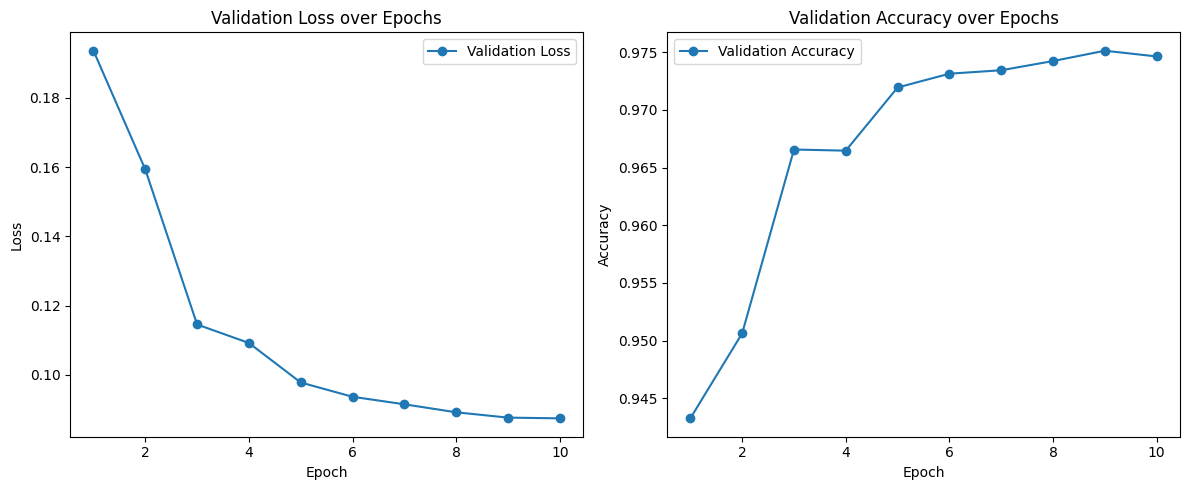

In [61]:
# Plotting
epochs = range(1, 11)  # Assuming you trained for 10 epochs

plt.figure(figsize=(12, 5))

# Plot validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

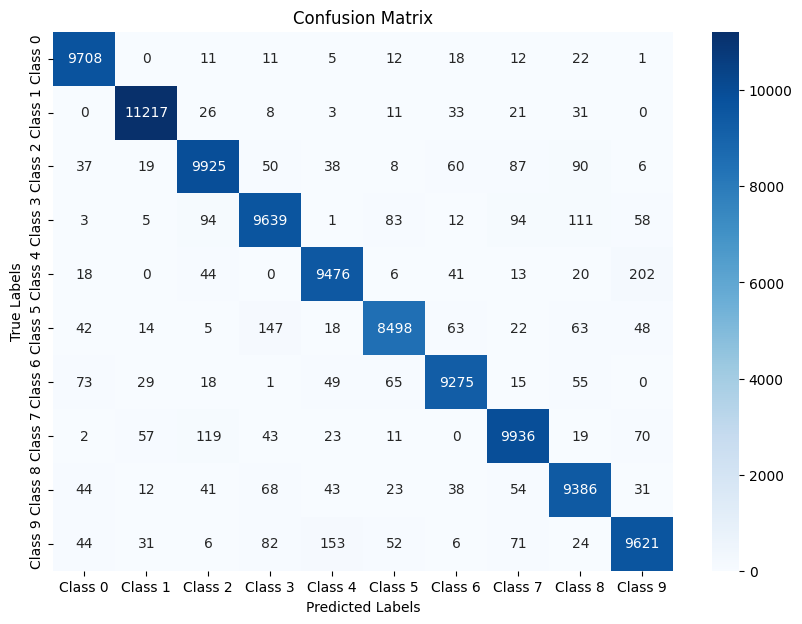

In [57]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(conf_matrix.shape[1])],
            yticklabels=[f'Class {i}' for i in range(conf_matrix.shape[0])])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

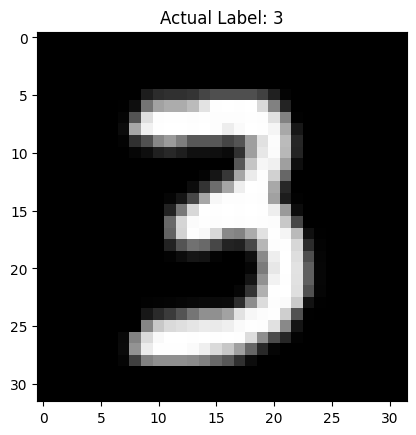

Prediksi: 3


In [95]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# Load dataset MNIST
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize MNIST gambar ke ukuran 32x32
    transforms.ToTensor(),  # Ubah jadi tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalisasi untuk grayscale (1 channel)
])

# Load dataset MNIST
dataset = MNIST(root="./data", train=False, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Fungsi untuk menampilkan gambar dan prediksi
def predict_mnist(image_tensor):
    # Model evaluasi mode
    model.eval()

    # Ubah gambar jadi 1D tensor (karena model menerima input 1D)
    image = image_tensor.view(-1, 32 * 32).to(device)

    # Prediksi
    output = model(image)
    pred = output.argmax(dim=1)

    # Konversi prediksi ke label
    label = dataset.classes[pred.item()]  # pastikan dataset.classes berisi label dari MNIST (0-9)

    return pred.item()  # return angka labelnya

# Contoh penggunaan
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Tampilkan gambar menggunakan matplotlib
plt.imshow(images[0].squeeze(), cmap="gray")
plt.title(f"Actual Label: {labels[0].item()}")
plt.show()

# Prediksi gambar
label_predicted = predict_mnist(images[0])
print(f"Prediksi: {label_predicted}")